# Virus UR clusters logos

Run first the first cell (Computing the clusters) and then the third cell (displaying the clusters' logos). The second cell can be used to display the clusters to stdout.

## Computing the clusters

In [4]:
import pandas as pd
import os, sys
import re
from Bio import motifs, SeqIO
from Bio.Seq import Seq
import matplotlib.pyplot as plt
from collections import OrderedDict
import subprocess
from pprint import pprint

import mysequtils as myut
import myseqclusters as mycl
import myseq_logo as mysl
import pald_funcs as mypal # my palindrome functions


mlens = [3, 4, 5]
num_tst_vtaxids = 10 # the number of vtaxids with the most common UR to process

# starcode parameters (we use Starcode to cluster)
str_exe = '~/work/mystuff/tools/starcode/starcode'
str_clst_type = 'mp' #''sp' # 'mp' for message-passing algorithm , or 'sp' for sphere algorithm
clst_path = './clst_data' # will be appended with _mp or _ph based on str_clst_type
clst_bfname = 'ur' # file name is clst_bfname_<vtaxid>_<mlen>.seq for UR and .clst for clusters

# UR information
base_path = '/Users/yoramzarai/work/school/Simulation/Viruses/VUR/viruses/'
dtype_rnd = {'vtaxid':int, 'num_cds':int, 'signf_common':str, 'signf_F1':str, 'signf_F2':str, 'signf_F3':str}
backg = {'A':0.25,'C':0.25,'G':0.25,'T':0.25}  # background for PSSM 
base_save_file = '' # 'v_most_URs_diff' code appends '.png' to save the figure and '.txt' to save the prints. 
                    #  Set to '' to disable 
# =============================================================================================================
print('Clustering using {} algorithm'.format(str_clst_type))

mmlens = ['m'+str(m) for m in mlens]

clst_path += '_'+str_clst_type 
os.makedirs(clst_path, exist_ok=True)
str_flags = ' -s --print-clusters' if str_clst_type=='sp' else ' -r 1 --print-clusters'

# handle for text file or sys.stdout
ftxt = open(base_save_file+'.txt', 'wt') if base_save_file!='' else sys.stdout

bfdata = os.path.join(clst_path, clst_bfname)
base_command = str_exe + str_flags

print('Starcode basic command: ', base_command)

'''keys are (vtaxid, mlen), and values are dictionaries containing
clusters information (where keys are the centroids and values are the corresponding
cluster's sequences)'''
ur_clst_info = OrderedDict()
for j, mlen in enumerate(mlens):
    rnd_model = 'dnt_samp' if mlen==3 else 'syn_perm+dnt_samp'
    mmlen = mmlens[j]
    xlsx_file = os.path.join(base_path, mmlens[j], rnd_model, 'Results', 'vsignf'+'_'+rnd_model+'_'+mmlens[j]+'.xlsx')
    df_vrnd = pd.read_excel(xlsx_file, header=0, dtype=dtype_rnd)
    vtaxids = df_vrnd.loc[:, 'vtaxid']  # vtaxid Series
    # find the vtaxids with the most common URs
    sgf = df_vrnd.loc[:,'signf_common']  # all common URs per vtaxid
    tmp = sgf.apply(lambda x:len(x.split('|'))) # this works on the values of sgf (which are the URs)
    srt_tmp = tmp.sort_values(ascending=False)
    for i in range(num_tst_vtaxids):
        indx = srt_tmp.index[i]  # vtaxid index in srt_tmp
        vtaxid = vtaxids.iloc[indx]
        ur = df_vrnd.iloc[indx]['signf_common'].split('|')
        eql_nt = {s for s in ur if len(set(s))==1}  # URs with the same nucleotides (e.g., AAAA)
        gc_nt = {s for s in ur if re.search('[CG]{'+str(mlen)+'}',s)}  # URs that contain only G and/or C
        at_nt = {s for s in ur if re.search('[AT]{'+str(mlen)+'}',s)}  # URs that contain only A and/or T
        
        # CHOOSE here what is proc_nt (the URs to show logos)
        #proc_nt = set(ur)-eql_nt # all UR other than the ones with equal NT
        proc_nt = set(ur)
        #proc_nt = gc_nt
        #proc_nt = at_nt
        #print('{}:\n\teql={} \n\tgc={}\n\tat={}\n\tproc={}'.format(vtaxid, eql_nt, gc_nt, at_nt, proc_nt), file=ftxt)
        if proc_nt and list(proc_nt)[0]!='nan':  # 'nan' is generated by pd.read_excel for empty cells
            _, _, _, m, _ = mysl.compute_pssm(proc_nt, backg, backg)
            rel_info = mysl.calc_rel_info(m, 'no')
            
            # clustering
            infile = '_'.join([bfdata, str(vtaxid), str(mlen)]) + '.seq'
            outfile = re.sub('.seq', '.clst', infile)
            myut.seq2plain_text_file(proc_nt, infile)  # generate input file
            # run startcode
            ret, sout = subprocess.getstatusoutput(base_command+' -i ' + infile  + ' -o ' + outfile)
            #print(sout)
            if ret == 0:
                # parse starcode output
                clusters = mycl.parse_starcode_cls_out(outfile)
                #print('Found {} clusters:'.format(len(clusters)))
                #for k in clusters.keys(): print(clusters[k])
                ur_clst_info[(vtaxid, mlen)]=clusters
            else:
                print('starcode errored and returned: ', sout)
            

Clustering using mp algorithm
Starcode basic command:  ~/work/mystuff/tools/starcode/starcode -r 1 --print-clusters


## Displaying sequence logos of clusters data 

NOTE: This cell doesn't have to be executed. It is only used to print the clusters

In [5]:
# MAKE SURE THE CELL ABOVE RUNS FIRST !!!

# ur_clst_info contains clusters information
for k in ur_clst_info:
    print('clusters for {}:'.format(k))
    val = ur_clst_info[k]
    print('number of subplots = ', sum( [len(val[kk])>1 for kk in val.keys()]))
    for i, kk in enumerate(val.keys()):
        print('  C{} ({} seq): {}'.format(i,len(val[kk]), val[kk]))




clusters for (1605721, 3):
number of subplots =  1
  C0 (12 seq): ['AGC', 'ATT', 'CAC', 'CCC', 'CTG', 'GAA', 'GCT', 'GGA', 'GTT', 'TCC', 'TGA', 'TTC']
clusters for (1273750, 3):
number of subplots =  1
  C0 (12 seq): ['AAA', 'AGA', 'CAA', 'CAT', 'CCG', 'CGC', 'CTA', 'CTC', 'GAC', 'GAG', 'GTC', 'TTG']
clusters for (1079999, 3):
number of subplots =  2
  C0 (7 seq): ['CTC', 'GCC', 'GCT', 'GGC', 'GTC', 'TGT', 'TTT']
  C1 (3 seq): ['AAA', 'AAT', 'ACA']
clusters for (1141526, 3):
number of subplots =  1
  C0 (10 seq): ['AAA', 'CAC', 'CCA', 'CTA', 'CTC', 'GAG', 'GAT', 'GGA', 'GTG', 'TTT']
clusters for (268746, 3):
number of subplots =  1
  C0 (9 seq): ['AAA', 'AAT', 'ACA', 'GCC', 'GCT', 'GGG', 'GTC', 'TGT', 'TTT']
clusters for (1029988, 3):
number of subplots =  1
  C0 (9 seq): ['ACA', 'CAA', 'GAC', 'GAG', 'GCC', 'GGA', 'TAG', 'TTG', 'TTT']
clusters for (1195085, 3):
number of subplots =  1
  C0 (9 seq): ['ACA', 'CAA', 'GAC', 'GAG', 'GGA', 'TAG', 'TGT', 'TTG', 'TTT']
clusters for (1283071, 3

## Displaying the clusters' logos

MAKE SURE THE FIRST CELL IS RAN FIRST !!

Figure saved in /Users/yoramzarai/work/school/Simulation/Viruses/vir_stat_jupyter/./clst_figs_mp/ur_1605721_3.png
Figure saved in /Users/yoramzarai/work/school/Simulation/Viruses/vir_stat_jupyter/./clst_figs_mp/ur_1273750_3.png
Figure saved in /Users/yoramzarai/work/school/Simulation/Viruses/vir_stat_jupyter/./clst_figs_mp/ur_1079999_3.png
Figure saved in /Users/yoramzarai/work/school/Simulation/Viruses/vir_stat_jupyter/./clst_figs_mp/ur_1141526_3.png
Figure saved in /Users/yoramzarai/work/school/Simulation/Viruses/vir_stat_jupyter/./clst_figs_mp/ur_268746_3.png
Figure saved in /Users/yoramzarai/work/school/Simulation/Viruses/vir_stat_jupyter/./clst_figs_mp/ur_1029988_3.png
Figure saved in /Users/yoramzarai/work/school/Simulation/Viruses/vir_stat_jupyter/./clst_figs_mp/ur_1195085_3.png
Figure saved in /Users/yoramzarai/work/school/Simulation/Viruses/vir_stat_jupyter/./clst_figs_mp/ur_1283071_3.png
Figure saved in /Users/yoramzarai/work/school/Simulation/Viruses/vir_stat_jupyter/./clst_

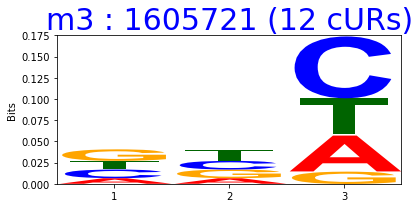

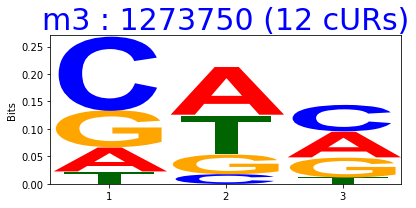

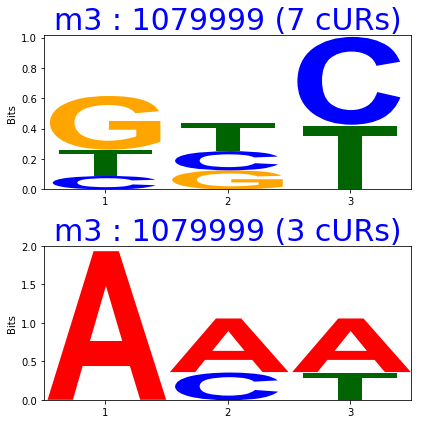

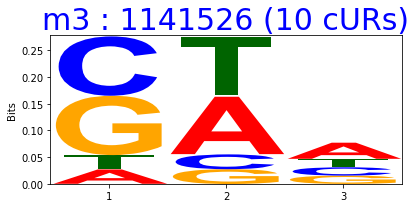

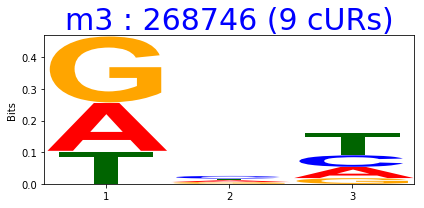

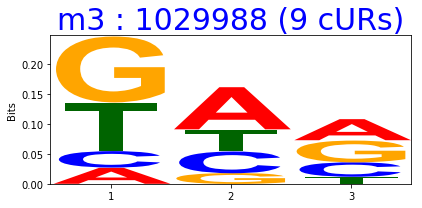

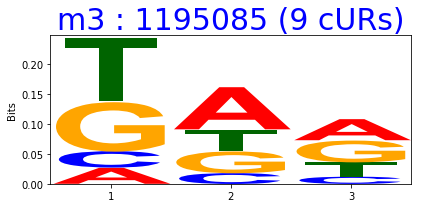

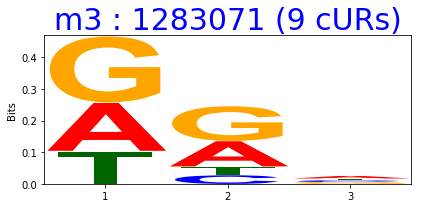

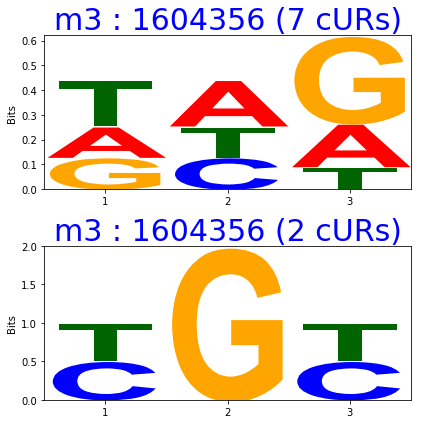

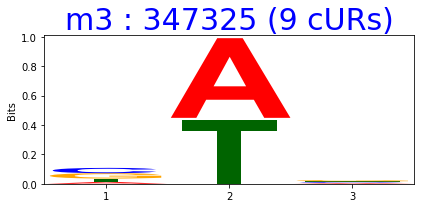

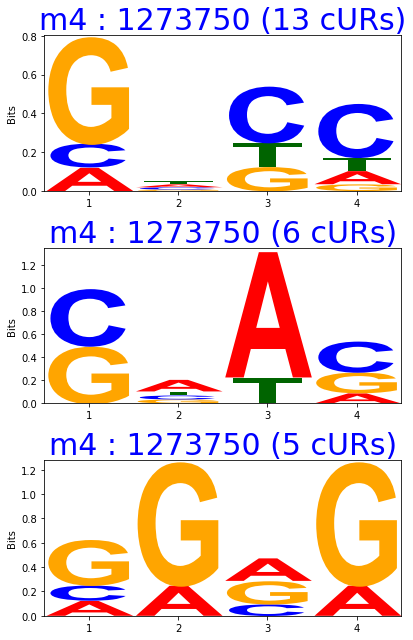

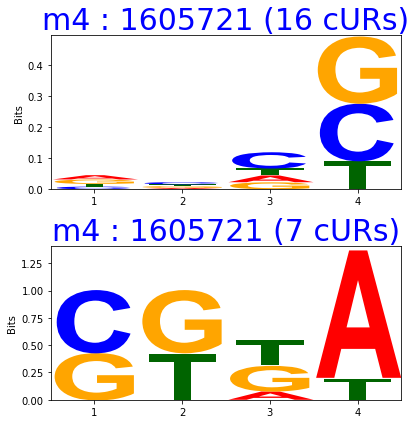

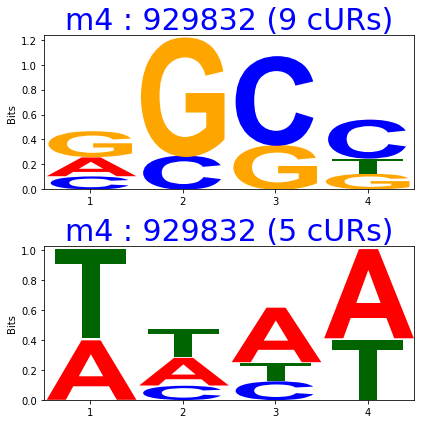

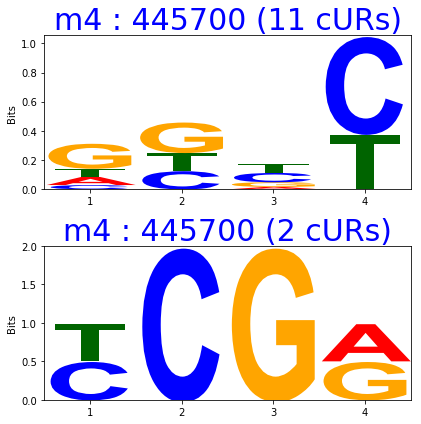

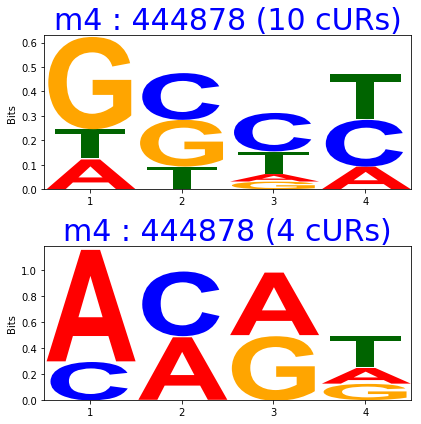

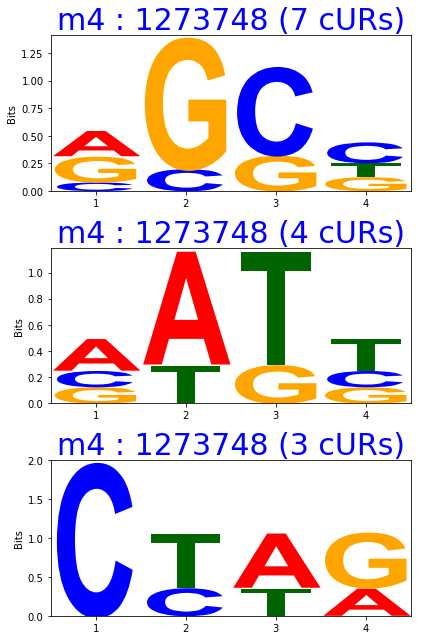

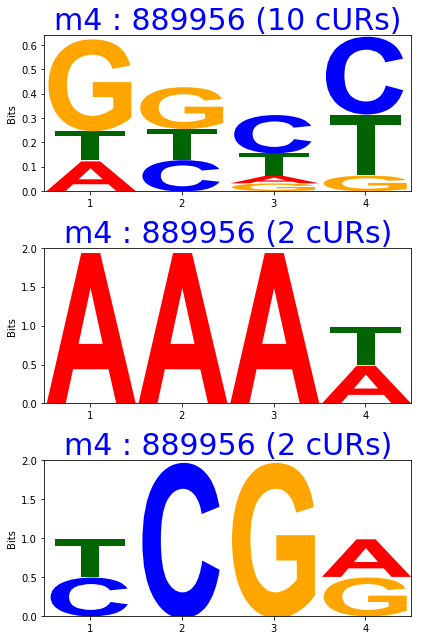

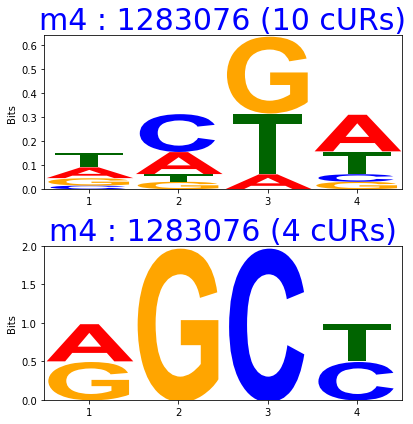

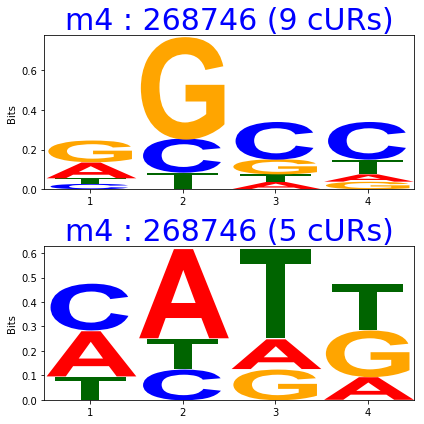

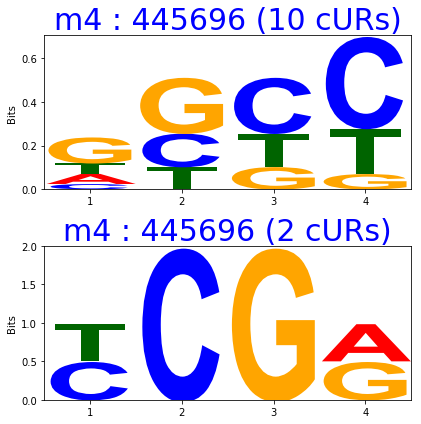

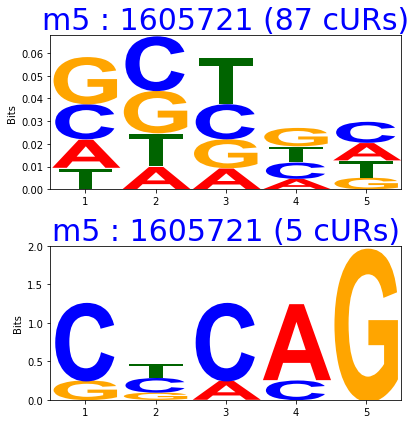

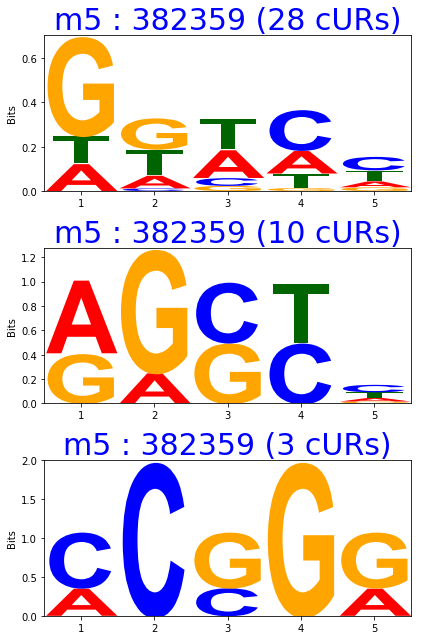

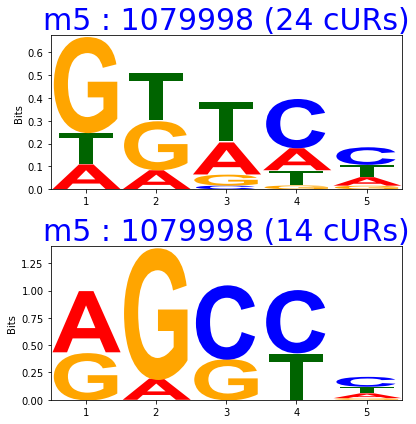

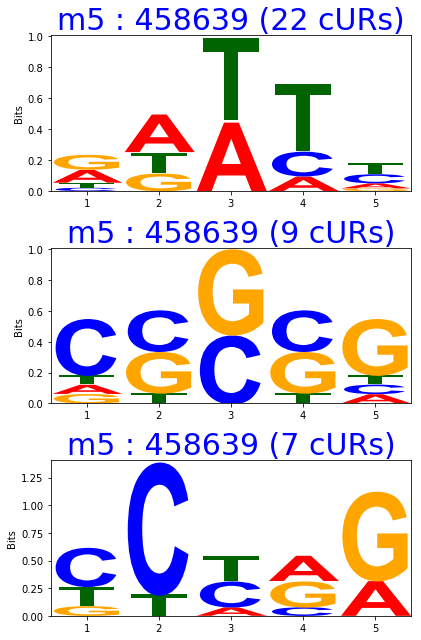

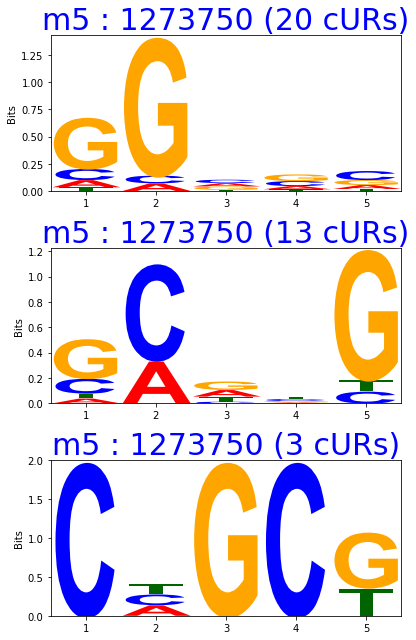

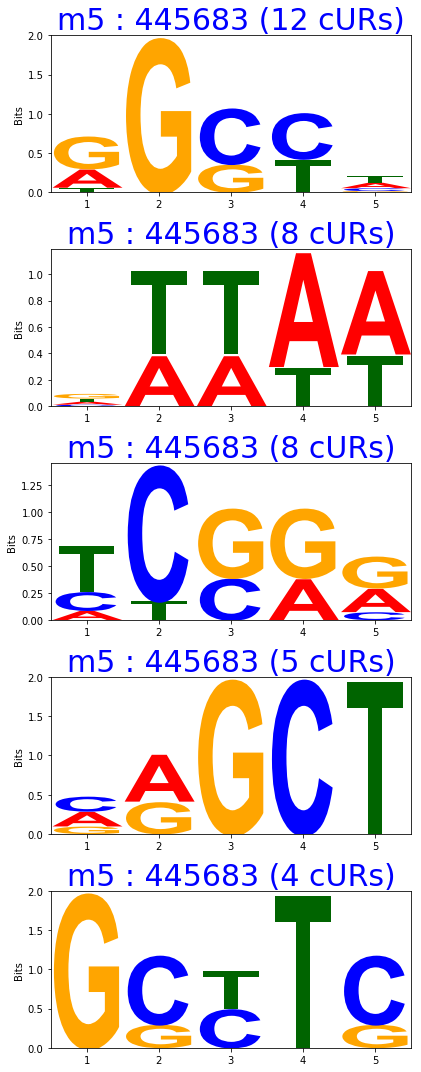

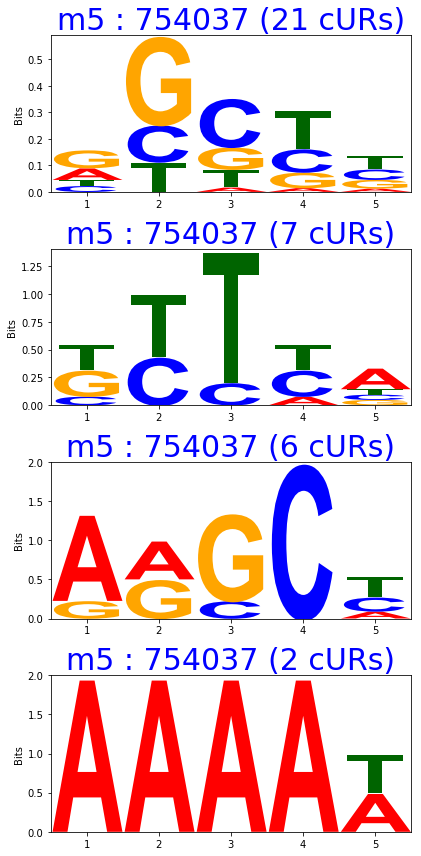

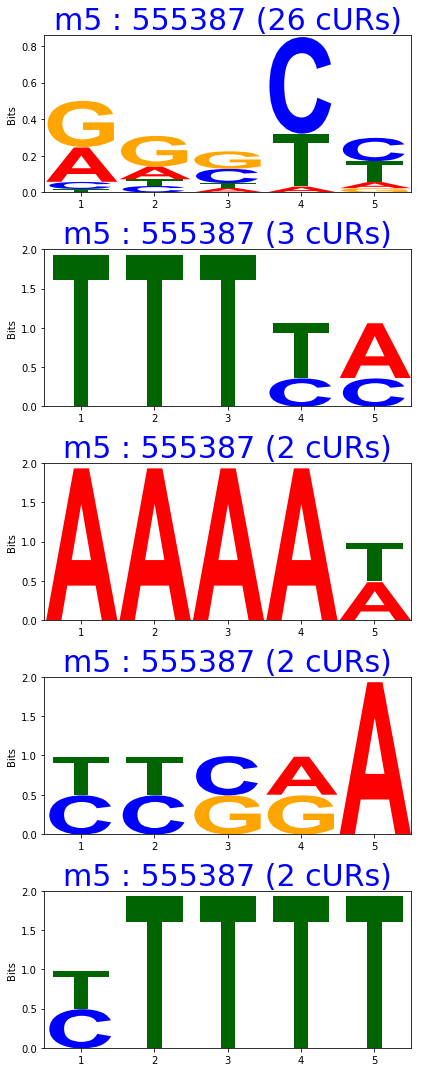

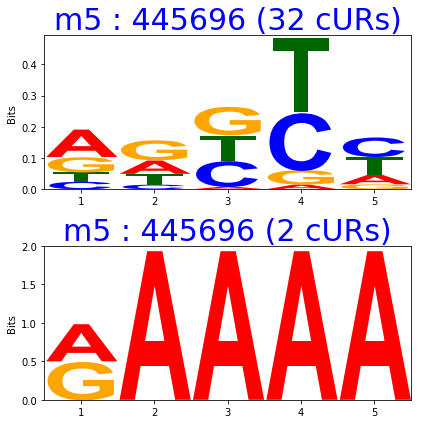

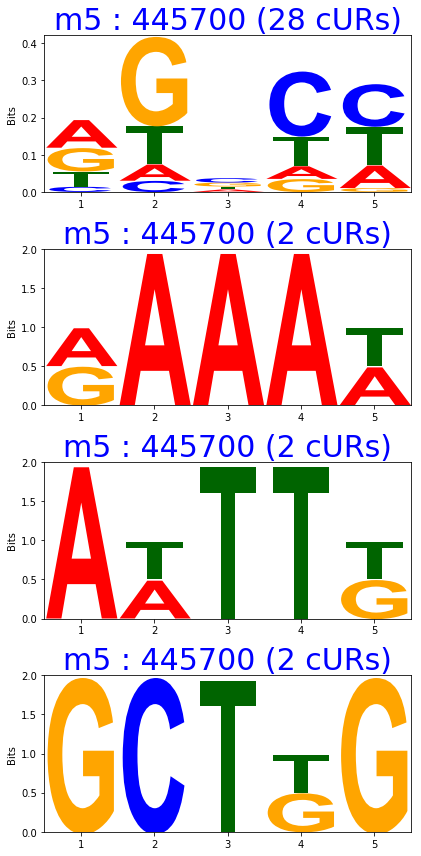

In [6]:
# MAKE SURE THE FIRST CELL RUNS FIRST !!!

import matplotlib.pyplot as plt
import myseq_logo as mysl
import pald_funcs as mypal # my palindrome functions
from Bio import motifs, SeqIO
from Bio.Seq import Seq

figs_path = './clst_figs'  # will be appended with _mp or _ph based on str_clst_type
figs_bfname = 'ur' # file name is figs_bfname_<vtaxid>_<mlen>.png
backg = {'A':0.25,'C':0.25,'G':0.25,'T':0.25}  # background for PSSM 
# =========================================================================================
figs_path += '_'+str_clst_type 
os.makedirs(figs_path, exist_ok=True)
base_fname = os.path.join(figs_path, figs_bfname)

# ur_clst_info contains clusters information
for k in ur_clst_info:
    vtaxid, mlen = k
    fname = '_'.join([base_fname, str(vtaxid), str(mlen)]) + '.png'
    # processing clusters that contain at least two sequences
    clsts = [v for kk, v in ur_clst_info[k].items() if len(v)>1]
    fig, axs = plt.subplots(len(clsts), 1, figsize=(6, 3*len(clsts)), squeeze=False)
    for i, c in enumerate(clsts):
        _, _, _, m, _ = mysl.compute_pssm(c, backg, backg)
        rel_info = mysl.calc_rel_info(m, 'no')
        maxy = mysl.gen_nt_sequence_logo(axs[i,0], rel_info)
        axs[i,0].set_title('m'+str(mlen)+' : '+str(vtaxid) + \
                           ' ('+str(len(c))+' cURs)',\
                               fontsize=30, color='blue')
        axs[i,0].set_ylabel('Bits')
        #axs[i,j].set_xlabel('NT index')
        axs[i,0].axis([0.5, mlen+0.5, 0, maxy])
        axs[i,0].set_xticks(range(1, mlen+1))
        
    plt.tight_layout()
    # save plot
    plt.savefig(fname, dpi=200)
    path = !pwd  # shell command
    print('Figure saved in {}/{}'.format(path[0], fname))


    
    

# Scratch Pad

In [ ]:
# SCRATCH PAD
########################
from pprint import pprint

a = (0,1)
b, c = a
print(b,c)


d = { 'a': [1,2], 'b': [1,2,3], 'c': [2], 'd': [1,2,3, 4, 5]}
pprint(d)

onlyv = [v for k,v in d.items() if len(v)>1]
for i, c in enumerate(onlyv):
    print(i, c)

k = {k: v for k,v in d.items() if len(v)>1}
pprint(k)
print(len(k))